# Steady State Heat Transfer

This is the implementation for steady state heat transfer in 2D using FEniCSx.
The boundary-value problem is described by:
$$
\begin{aligned}
-\Delta u(x) = f(x) &\quad x\in \Omega \\
u(x) = u_D(x) &\quad x\in \partial \Omega
\end{aligned}
$$

## Variational formulation

To calculate the variational formulation, we multiply the equation by a test function $v$ and integrate over $\Omega$:
$$\int_\Omega (-\Delta u)v dx = \int_\Omega f v dx$$

Using integration by parts to the LHS:
$$\int_\Omega \nabla u \cdot \nabla v dx - \int_{\partial\Omega} \frac{\partial u}{\partial n} v ds
    = \int_\Omega f v dx$$
Since the integral term on the boundary is 0, the equation becomes
$$\int_\Omega \nabla u \cdot \nabla v dx = \int_\Omega f v dx$$
leading to
$$
\begin{aligned}
a(u,v) &:= \int_\Omega \nabla u \cdot \nabla v dx\\
L(v) &:= \int_\Omega f v dx
\end{aligned}
$$

## Problem definition

- Domain: $\Omega = [0,2] \times [0,1]$
- Dirichlet BCs: $u = 0$ on $\{(0,y) \cup (2,y)\} \in \partial\Omega$
- Forcing fn: $f = 10 \exp(- ((x - 0.5)^2 + (y - 0.5)^2) / 0.02)$

In [5]:
# Import Libraries
from mpi4py import MPI
from dolfinx import mesh, fem, default_scalar_type, plot, io
import numpy as np
import ufl
from dolfinx.fem.petsc import LinearProblem
import pyvista
from pathlib import Path

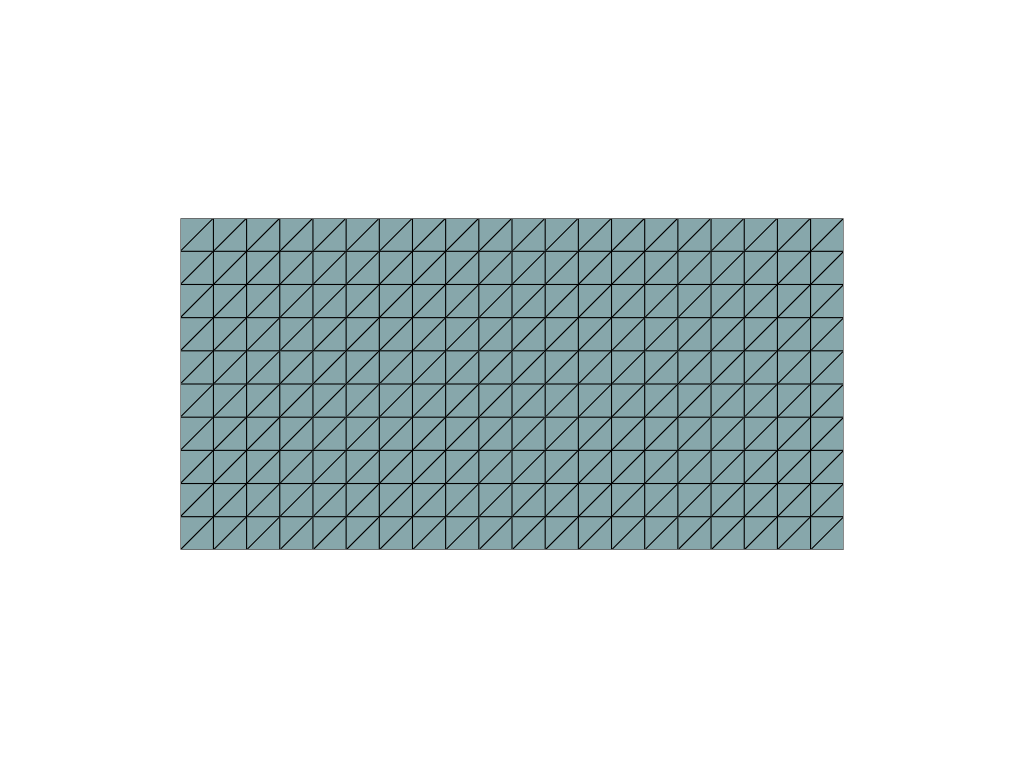

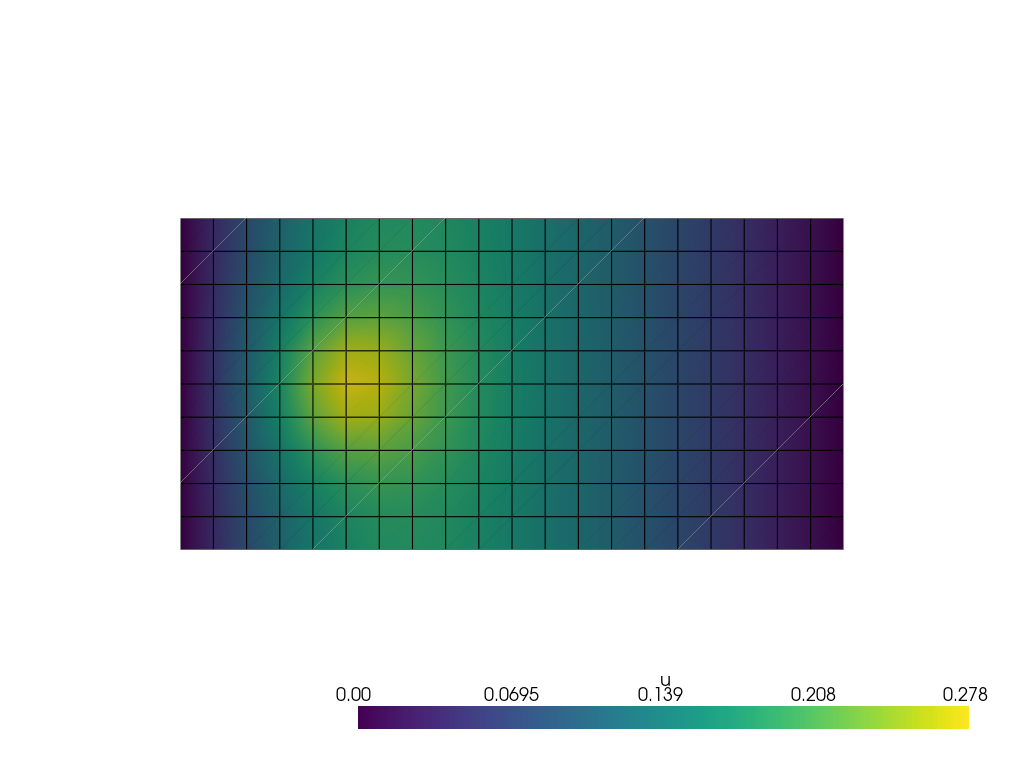

In [6]:
# Create mesh
domain = mesh.create_rectangle(MPI.COMM_WORLD, ((0.0, 0.0), (2.0, 1.0)), (20, 10), cell_type=mesh.CellType.quadrilateral)

# Create FunctionSpace
V = fem.functionspace(domain, ("Lagrange", 1))

# Apply Dirichlet BCs
# Identify the facets on the left and right boundaries
facets = mesh.locate_entities_boundary(domain, domain.topology.dim - 1, lambda x: np.isclose(x[0], 0.0) | np.isclose(x[0], 2.0))
# Locate DoFs on the facets
dofs_boundary = fem.locate_dofs_topological(V, domain.topology.dim - 1, facets)
# Create Dirichlet BCs
bc = fem.dirichletbc(default_scalar_type(0.0), dofs_boundary, V)

# Define variational problem
# Define trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
# Define source function
x = ufl.SpatialCoordinate(domain)
f = 10.0 * ufl.exp(- ((x[0] - 0.5)**2 + (x[1] - 0.5)**2) / 0.02)
# Define variational form
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = ufl.inner(f, v) * ufl.dx

# Solve variational problem
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Post-process
# Output visualisation
pyvista.start_xvfb()
domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
topology, cell_types, geometry = plot.vtk_mesh(domain, domain.topology.dim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)
plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
plotter.show()
# Plot solution
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(V)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
u_plotter.show()
# Save solution to file
results_folder = Path("results")
results_folder.mkdir(exist_ok=True, parents=True)
filename = results_folder / "out_ssht"
with io.VTXWriter(domain.comm, filename.with_suffix(".bp"), [uh]) as vtx:
    vtx.write(0.0)
with io.XDMFFile(domain.comm, filename.with_suffix(".xdmf"), "w") as xdmf:
    xdmf.write_mesh(domain)
    xdmf.write_function(uh)